In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob, os
import pandas as pd
import numpy as np
import seaborn as sns
from itertools import product
import matplotlib.pyplot as plt
import utils

In [3]:
from pathlib import Path
current_working_directory = Path.cwd()

In [4]:
ENERGY_METRICS = ['PACKAGE_ENERGY (J)']

In [5]:
DATAPATH = f"../data/nuc_data.csv"

In [6]:
data = pd.read_csv(DATAPATH)

In [7]:
data.columns

Index(['__run_id', '__done', 'subject', 'target', 'cache-references',
       'cache-misses', 'LLC-loads', 'LLC-load-misses', 'LLC-stores',
       'LLC-store-misses', 'cache-misses_percent', 'LLC-load-misses_percent',
       'LLC-store-misses_percent', 'DRAM_ENERGY (J)', 'PACKAGE_ENERGY (J)',
       'PP0_ENERGY (J)', 'PP1_ENERGY (J)', 'TOTAL_MEMORY', 'TOTAL_SWAP',
       'USED_MEMORY', 'USED_SWAP', 'execution_time', 'PROCESS_CPU_USAGE',
       'PROCESS_MEMORY', 'PROCESS_VIRTUAL_MEMORY', 'CPU_USAGE_0',
       'CPU_USAGE_1', 'CPU_USAGE_2', 'CPU_USAGE_3', 'CPU_USAGE_4',
       'CPU_USAGE_5', 'CPU_USAGE_6', 'CPU_USAGE_7', 'CPU_USAGE_8',
       'CPU_USAGE_9', 'CPU_USAGE_10', 'CPU_USAGE_11', 'CPU_FREQUENCY_0',
       'CPU_FREQUENCY_1', 'CPU_FREQUENCY_2', 'CPU_FREQUENCY_3',
       'CPU_FREQUENCY_4', 'CPU_FREQUENCY_5', 'CPU_FREQUENCY_6',
       'CPU_FREQUENCY_7', 'CPU_FREQUENCY_8', 'CPU_FREQUENCY_9',
       'CPU_FREQUENCY_10', 'CPU_FREQUENCY_11'],
      dtype='object')

In [8]:
# Convert to KJ and add Total Energy
data['PACKAGE_ENERGY (J)'] = data['PACKAGE_ENERGY (J)'] / 1000
#data['DRAM_ENERGY (J)'] = data['DRAM_ENERGY (J)'] / 1000
data['PP0_ENERGY (J)'] = data['PP0_ENERGY (J)'] / 1000
data['TOTAL_ENERGY'] = data['PACKAGE_ENERGY (J)'] #+ data['DRAM_ENERGY (J)']
data['CACHE_ENERGY'] = data['PACKAGE_ENERGY (J)'] - data['PP0_ENERGY (J)']
data.rename(
    columns={'PACKAGE_ENERGY (J)': 'PACKAGE_ENERGY (KJ)', 'PP0_ENERGY (J)': 'PP0_ENERGY (KJ)' }, inplace=True
)

In [9]:
ENERGY_METRICS = ['PACKAGE_ENERGY (J) (KJ)', 'TOTAL_ENERGY']

In [10]:
#subjects = list(set(data['subject'].values))
subjects = ['cpython', 'pypy', 'numba', 'pyston-lite', 'py3.13-jit', 'nuitka', 'cython', 'codon', 'mypyc']
targets = ['mandelbrot', 'fannkuch_redux', 'binary_trees', 'n_body', 'spectralnorm', 'k_nucleotide', 'fasta']
GROUPS = list(
    product(subjects, targets)
)

In [11]:
data['subject'] = pd.Categorical(
    data['subject'],
    ['cpython', 'pypy', 'numba', 'pyston-lite', 'py3.13-jit', 'nuitka', 'cython', 'codon', 'mypyc']
)

## Descriptive Statistics

### Descriptive Statistics per Benchmark

In [12]:
def reform(dictionary):
    return {(outerKey, innerKey): values for outerKey, innerDict in dictionary.items() for innerKey, values in innerDict.items()}

In [13]:
descriptive = []
for subject in subjects:
    row = {}
    row['subject'] = subject

    for target in targets:
        df = utils.get_rows_by_subject_target(data, subject, target)
        #stats = {'subject': subject, 'target' : target} | reform(df[ENERGY_METRICS].describe().to_dict())

        row[(target, 'PACKAGE')] = df['PACKAGE_ENERGY (KJ)'].mean()
        #row[(target, 'DRAM')] = df['DRAM_ENERGY (KJ)'].mean()
        row[(target, 'CACHE')] = df['CACHE_ENERGY'].mean()
        row[(target, 'CPU')] = df['PP0_ENERGY (KJ)'].mean()
        
    descriptive.append(row)

#columns = pd.MultiIndex.from_product([targets, ['CPU', 'DRAM']])
table = pd.DataFrame(descriptive)
table = table.sort_values(by='subject')
table

,subject,"(mandelbrot, PACKAGE)","(mandelbrot, CACHE)","(mandelbrot, CPU)","(fannkuch_redux, PACKAGE)","(fannkuch_redux, CACHE)","(fannkuch_redux, CPU)","(binary_trees, PACKAGE)","(binary_trees, CACHE)","(binary_trees, CPU)",...,"(n_body, CPU)","(spectralnorm, PACKAGE)","(spectralnorm, CACHE)","(spectralnorm, CPU)","(k_nucleotide, PACKAGE)","(k_nucleotide, CACHE)","(k_nucleotide, CPU)","(fasta, PACKAGE)","(fasta, CACHE)","(fasta, CPU)"
7,codon,0.449868,0.251646,0.198222,0.479021,0.275223,0.203798,0.171481,0.097681,0.073800,...,0.011321,0.022744,0.013489,0.009255,0.308360,0.175533,0.132826,0.122541,0.067705,0.054837
0,cpython,6.132766,3.195765,2.937001,16.015263,8.316581,7.698682,8.257877,4.993920,3.263957,...,1.815395,3.246241,1.701841,1.544401,1.805672,0.963605,0.842067,1.916361,0.999624,0.916737
6,cython,5.740540,3.105800,2.634740,12.472588,6.481880,5.990708,6.882239,4.390013,2.492226,...,3.177652,2.699363,1.409050,1.290312,1.593141,0.856243,0.736898,1.955985,1.022111,0.933873
8,mypyc,6.496425,3.486203,3.010223,16.690730,8.703792,7.986938,2.558892,1.620855,0.938038,...,2.810359,3.331005,1.810950,1.520056,1.951374,1.052452,0.898922,2.228031,1.172763,1.055269
5,nuitka,5.150897,2.860436,2.290461,12.142858,6.317311,5.825547,6.690559,4.287521,2.403038,...,2.774519,2.140229,1.111655,1.028574,1.386095,0.732596,0.653499,1.601419,0.833528,0.767891
2,numba,0.557042,0.305369,0.251673,0.470558,0.257927,0.212630,0.330296,0.189591,0.140705,...,0.027606,1.212878,0.740027,0.472852,0.213204,0.116841,0.096362,0.658116,0.357232,0.300884
4,py3.13-jit,6.874100,3.574851,3.299249,10.364393,5.233235,5.131158,3.869664,2.374036,1.495628,...,1.822902,2.962230,1.574311,1.387919,2.105310,1.135641,0.969668,2.304515,1.165335,1.139181
1,pypy,0.886321,0.464202,0.422119,0.830567,0.439915,0.390651,0.540677,0.314816,0.225861,...,0.074757,0.123721,0.070971,0.052750,0.659253,0.372095,0.287159,0.136286,0.074157,0.062129
3,pyston-lite,6.182866,3.223859,2.959006,15.999927,8.309880,7.690047,7.892561,4.960315,2.932246,...,1.817520,3.230761,1.696613,1.534148,1.801260,0.960549,0.840711,1.918086,0.999881,0.918205


In [14]:
latex_table = table.round(3).to_latex(index=False, float_format="%.2f")
print(latex_table)

\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrr}
\toprule
subject & ('mandelbrot', 'PACKAGE') & ('mandelbrot', 'CACHE') & ('mandelbrot', 'CPU') & ('fannkuch_redux', 'PACKAGE') & ('fannkuch_redux', 'CACHE') & ('fannkuch_redux', 'CPU') & ('binary_trees', 'PACKAGE') & ('binary_trees', 'CACHE') & ('binary_trees', 'CPU') & ('n_body', 'PACKAGE') & ('n_body', 'CACHE') & ('n_body', 'CPU') & ('spectralnorm', 'PACKAGE') & ('spectralnorm', 'CACHE') & ('spectralnorm', 'CPU') & ('k_nucleotide', 'PACKAGE') & ('k_nucleotide', 'CACHE') & ('k_nucleotide', 'CPU') & ('fasta', 'PACKAGE') & ('fasta', 'CACHE') & ('fasta', 'CPU') \\
\midrule
codon & 0.45 & 0.25 & 0.20 & 0.48 & 0.28 & 0.20 & 0.17 & 0.10 & 0.07 & 0.03 & 0.02 & 0.01 & 0.02 & 0.01 & 0.01 & 0.31 & 0.18 & 0.13 & 0.12 & 0.07 & 0.06 \\
cpython & 6.13 & 3.20 & 2.94 & 16.02 & 8.32 & 7.70 & 8.26 & 4.99 & 3.26 & 3.77 & 1.95 & 1.81 & 3.25 & 1.70 & 1.54 & 1.81 & 0.96 & 0.84 & 1.92 & 1.00 & 0.92 \\
cython & 5.74 & 3.11 & 2.63 & 12.47 & 6.48 & 5.99 & 6.88 & 4.39 & 2

### Aggregated Descriptive Statistics

In [15]:
descriptive = []
for subject in subjects:
    df = data[data['subject'] == subject]
    stats = {'subject': subject} | reform(df[['PACKAGE_ENERGY (KJ)', 'PP0_ENERGY (KJ)']].describe().to_dict())
    row = {
        'subject': subject,
        ('PACKAGE_ENERGY (KJ)', 'mean'): stats[('PACKAGE_ENERGY (KJ)', 'mean')],
        ('PACKAGE_ENERGY (KJ)', 'std'): stats[('PACKAGE_ENERGY (KJ)', 'std')],
        ('PACKAGE_ENERGY (KJ)', 'CV'): stats[('PACKAGE_ENERGY (KJ)', 'std')] / stats[('PACKAGE_ENERGY (KJ)', 'mean')],
        ('PP0_ENERGY (KJ)', 'mean'): stats[('PP0_ENERGY (KJ)', 'mean')],
        ('PP0_ENERGY (KJ)', 'std'): stats[('PP0_ENERGY (KJ)', 'std')],
        ('PP0_ENERGY (KJ)', 'CV'): stats[('PP0_ENERGY (KJ)', 'std')] / stats[('PP0_ENERGY (KJ)', 'mean')]
    }
    descriptive.append(row)

#columns = pd.MultiIndex.from_product([ENERGY_METRICS, ['mean', 'std', 'min', '50%', 'max']])
table = pd.DataFrame(descriptive)
table = table.sort_values(by='subject')
table

,subject,"(PACKAGE_ENERGY (KJ), mean)","(PACKAGE_ENERGY (KJ), std)","(PACKAGE_ENERGY (KJ), CV)","(PP0_ENERGY (KJ), mean)","(PP0_ENERGY (KJ), std)","(PP0_ENERGY (KJ), CV)"
7,codon,0.225868,0.176573,0.781754,0.097723,0.076791,0.785810
0,cpython,5.877416,4.710790,0.801507,2.716891,2.266209,0.834118
6,cython,5.430925,3.558744,0.655274,2.465201,1.692335,0.686490
8,mypyc,5.590792,4.848233,0.867182,2.602829,2.354710,0.904673
5,nuitka,4.984460,3.548421,0.711897,2.249076,1.669418,0.742269
2,numba,0.500443,0.348325,0.696033,0.214673,0.136908,0.637752
4,py3.13-jit,4.609518,2.855856,0.619556,2.177958,1.523482,0.699500
1,pypy,0.477502,0.310442,0.650138,0.216489,0.146348,0.676006
3,pyston-lite,5.828380,4.656809,0.798989,2.670269,2.207624,0.826742


## BarPlots

In [16]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [17]:
darker_colors = [
    "#BA3636",  # Enhanced Darker Coral Red
    "#30928C",  # Enhanced Darker Turquoise
    "#DC6E45",  # Enhanced Darker Light Salmon
    "#462865",  # Enhanced Darker Purple
    "#BEA200",  # Enhanced Darker Gold
    "#2E859C",  # Enhanced Darker Sky Blue
    "#6BA393",  # Enhanced Darker Mint
    "#C13E8A",  # Enhanced Darker Hot Pink
    "#5F300D"   # Enhanced Darker Saddle Brown
]

colors = [
    "#FF6B6B",  # Coral Red
    "#4ECDC4",  # Turquoise
    "#FFA07A",  # Light Salmon
    "#6A3D9A",  # Purple
    "#FFD700",  # Gold
    "#45B7D1",  # Sky Blue
    "#98D8C8",  # Mint
    "#FF69B4",  # Hot Pink
    "#8B4513"   # Saddle Brown
]

brighter_colors = [
    "#FFB3B3",  # Enhanced Brighter Coral Red
    "#B3FFE6",  # Enhanced Brighter Turquoise
    "#FFD6B3",  # Enhanced Brighter Light Salmon
    "#D6B3FF",  # Enhanced Brighter Purple
    "#FFFFB3",  # Enhanced Brighter Gold
    "#B3E6FF",  # Enhanced Brighter Sky Blue
    "#E6FFE6",  # Enhanced Brighter Mint
    "#FFB3D9",  # Enhanced Brighter Hot Pink
    "#D6B399"   # Enhanced Brighter Saddle Brown
]


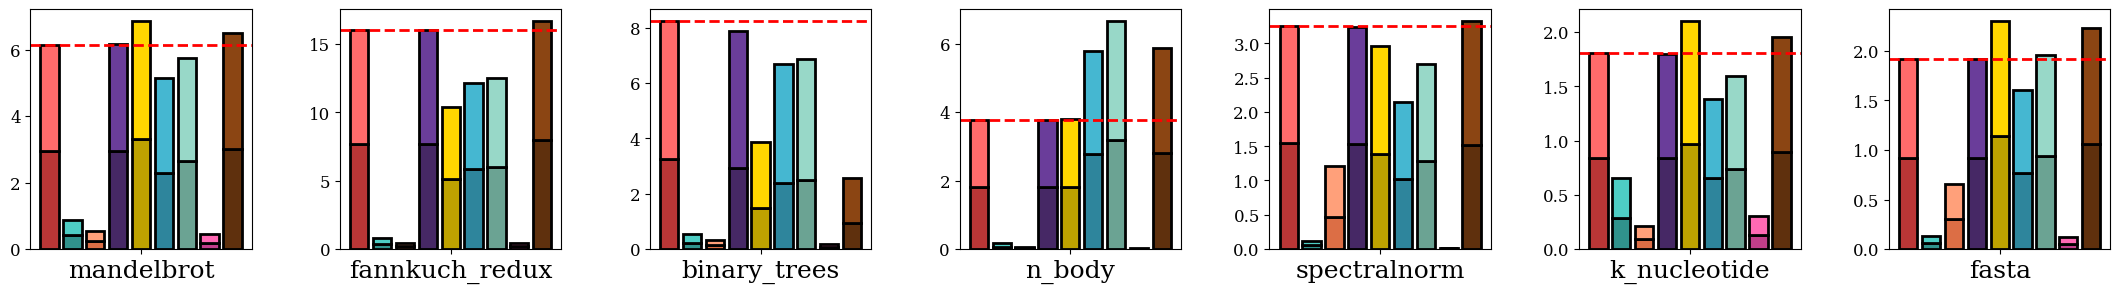

In [18]:
plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})
fig, axes = plt.subplots(1, 7, figsize=(26, 3))
axs_flat = axes.flatten()

for i in range(7):
    df = data[data['target'] == targets[i]]
    #df = df.sort_values(by='subject')

    total_energy = df.groupby('subject')['PP0_ENERGY (KJ)'].mean()
    cache_energy = df.groupby('subject')['CACHE_ENERGY'].mean()

    # Plot stacked bars
    axs_flat[i].bar(total_energy.index, total_energy, label='PP0_ENERGY', color=darker_colors, edgecolor='black', linewidth=2)
    axs_flat[i].bar(cache_energy.index, cache_energy, bottom=total_energy, label='CACHE_ENERGY', color=colors, edgecolor='black',  linewidth=2)
    # Add horizontal line on top of the first bar at the left
    first_bar_height = total_energy.iloc[0] + cache_energy.iloc[0]
    axs_flat[i].axhline(y=first_bar_height, color='red', linestyle='--', linewidth=2)
    # Set target as single x tick in the middle
    axs_flat[i].set_xticks([len(total_energy) // 2])
    axs_flat[i].set_xticklabels([targets[i]], fontsize=18)
    
    axs_flat[i].set_xlabel('')
    axs_flat[i].set_ylabel('')

plt.subplots_adjust(wspace=0)
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9, hspace=0.4, wspace=0.4)

plt.savefig(f"nuc_energy_stacked.pdf", format="pdf", dpi=300, bbox_inches="tight", transparent=True)

plt.show()

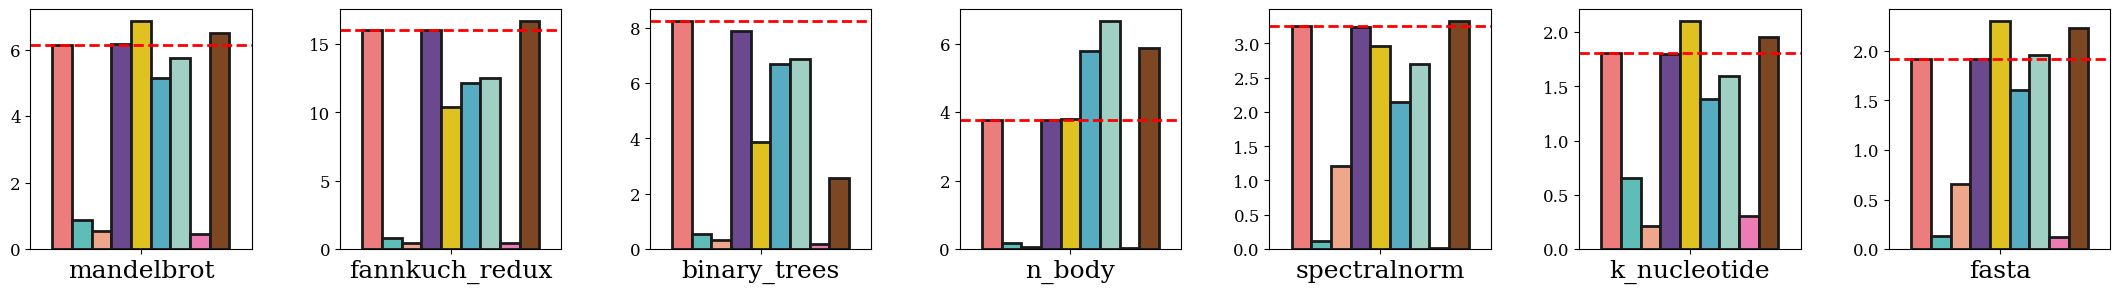

In [19]:
plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})
fig, axes = plt.subplots(1, 7, figsize=(26, 3))
axs_flat = axes.flatten()

for i in range(7):
    df = data[data['target'] == targets[i]]
    df.sort_values(by='subject')

    sns.barplot(
        x="target", y='TOTAL_ENERGY', hue="subject", capsize = 0.5, errorbar=None, edgecolor = '0.1', lw=2, data=df, ax = axs_flat[i], dodge=True,
        palette=colors
    )
    axs_flat[i].get_legend().remove()
    axs_flat[i].set_xlabel('')
    axs_flat[i].set_ylabel('')
    axs_flat[i].tick_params(axis='x', labelsize=18)
    
    first_bar = axs_flat[i].patches[0]
    bar_height = first_bar.get_height()
    axs_flat[i].axhline(y=bar_height, color='red', linestyle='--', linewidth=2)
        
plt.subplots_adjust(wspace=0)
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9, hspace=0.4, wspace=0.4)

plt.savefig(f"nuc_energy.pdf", format="pdf", dpi=300, bbox_inches="tight", transparent=True)

plt.show()

## Normality

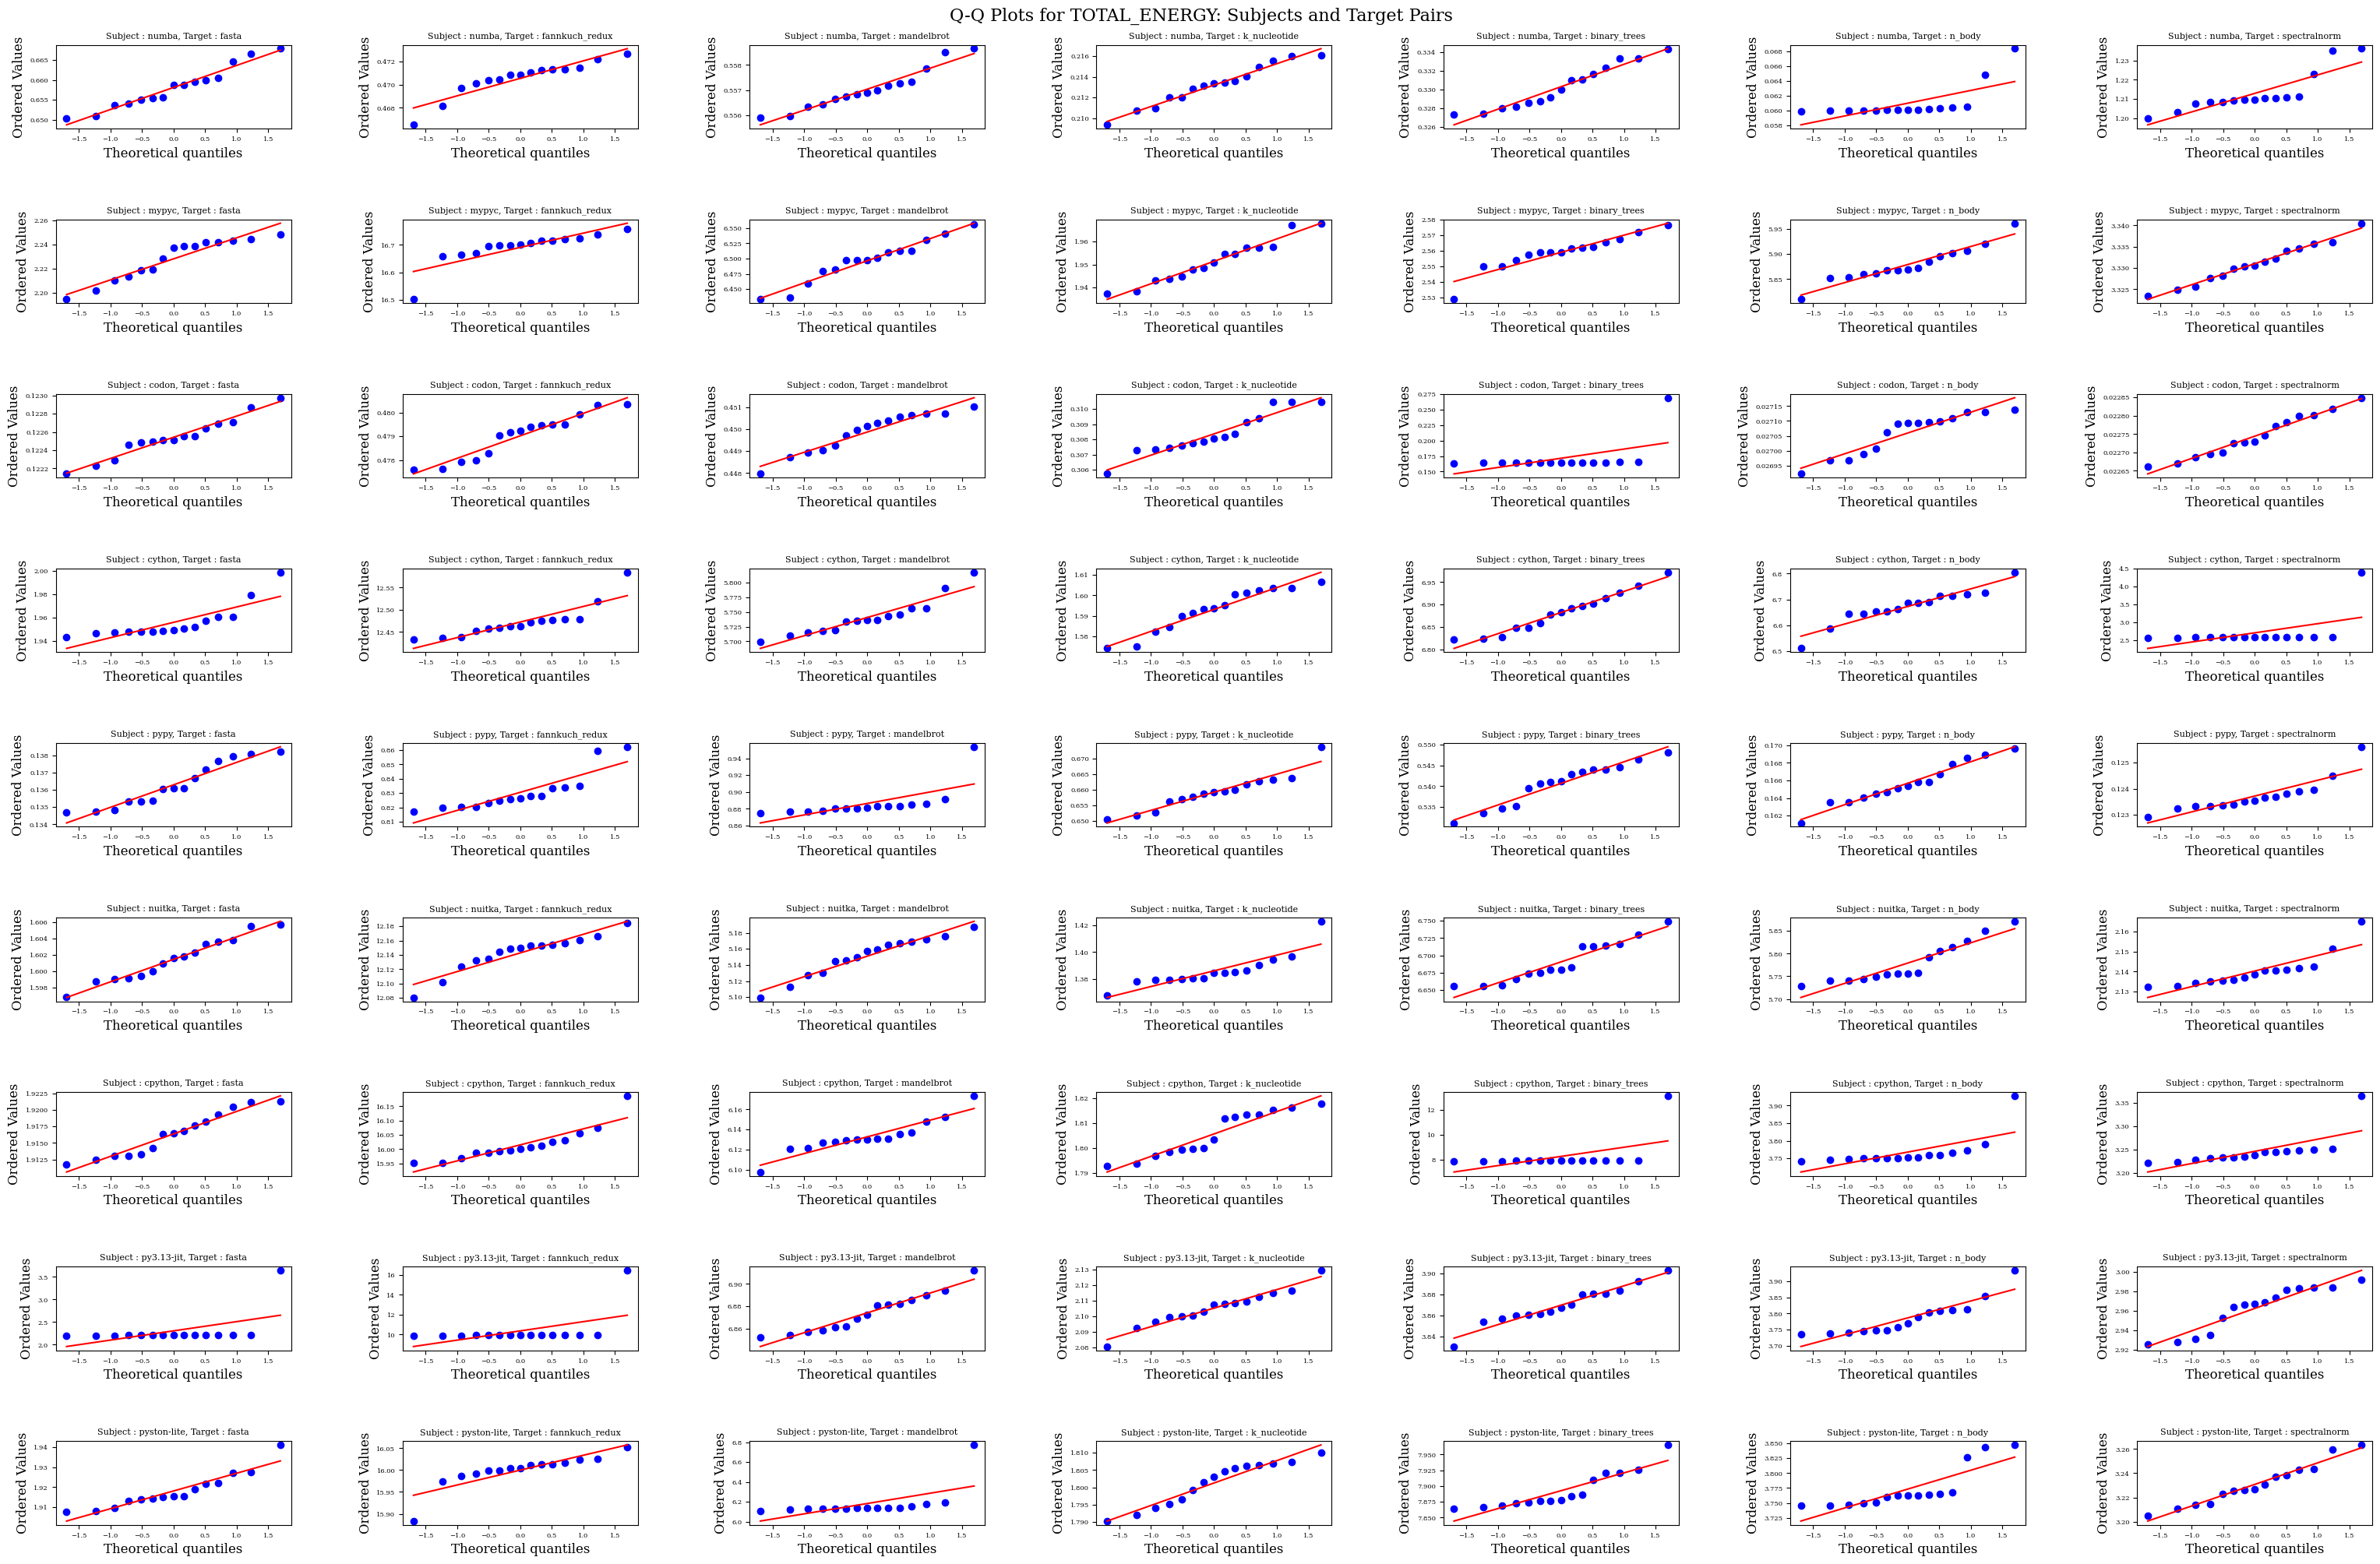

In [20]:
utils.plot_qq_grid(data, 'TOTAL_ENERGY')

### Shapiro-Wilk Aggregated 

In [21]:
from scipy import stats

In [22]:
descriptive = []
for subject in subjects:
    df = data[data['subject'] == subject]['TOTAL_ENERGY']
    statistic, p_value = stats.shapiro(df)
    print(subject, p_value)

cpython 1.1196742870764608e-11
pypy 3.52591611107606e-10
numba 4.246597458226982e-08
pyston-lite 9.468898034617587e-12
py3.13-jit 3.763257850714577e-11
nuitka 6.828446097359074e-10
cython 1.6954854073744445e-09
codon 3.328022872056412e-09
mypyc 1.0587592558432734e-13


### Shapiro-Wilk per Benchmark

In [23]:
descriptive = []
for subject, target in GROUPS:
    df = utils.get_rows_by_subject_target(data, subject, target)['TOTAL_ENERGY']
    statistic, p_value = stats.shapiro(df)
    row = {'subject': subject, 'target' : target, 'p-value' : p_value, 'normal?' : 'normal' if p_value > 0.05 else 'maybe not'}
    descriptive.append(row)

pd.DataFrame(descriptive)

,subject,target,p-value,normal?
0,cpython,mandelbrot,1.153996e-01,normal
1,cpython,fannkuch_redux,8.658720e-03,maybe not
2,cpython,binary_trees,1.229588e-07,maybe not
3,cpython,n_body,3.711668e-06,maybe not
4,cpython,spectralnorm,8.682180e-06,maybe not
...,...,...,...,...
58,mypyc,binary_trees,1.075566e-01,normal
59,mypyc,n_body,4.580555e-01,normal
60,mypyc,spectralnorm,9.817992e-01,normal
61,mypyc,k_nucleotide,6.167826e-01,normal


## Kruskal

In [24]:
from scipy.stats import kruskal

In [25]:
samples = []
for subject in subjects:
    df = data[data['subject'] == subject]['TOTAL_ENERGY']
    samples.append(df.to_list())

stat, p_value = kruskal(*samples)
print({'stat': stat, 'p_value': p_value})

{'stat': 638.3307548511539, 'p_value': 1.3372800100469601e-132}


## Cliffs Delta

In [26]:
from cliffs_delta import cliffs_delta
import itertools

In [27]:
# Baseline - CPython Group
baseline = [utils.get_rows_by_subject_target(data, 'cpython', target)['TOTAL_ENERGY'].to_list() for target in targets]
baseline = list(itertools.chain(*baseline))

In [28]:
rows = []
for subject in subjects:
    sample = [utils.get_rows_by_subject_target(data, subject, target)['TOTAL_ENERGY'].to_list() for target in targets]
    sample = list(itertools.chain(*sample))
    value, difference = cliffs_delta(baseline, sample)
    row = {'subject': subject, 'value': value, 'difference': difference}
    rows.append(row)

cliffs = pd.DataFrame(rows)
cliffs

,subject,value,difference
0,cpython,0.000000,negligible
1,pypy,1.000000,large
2,numba,1.000000,large
3,pyston-lite,0.010794,negligible
4,py3.13-jit,-0.002812,negligible
5,nuitka,0.145578,negligible
6,cython,0.017687,negligible
7,codon,1.000000,large
8,mypyc,-0.017687,negligible


In [29]:
latex_table = cliffs.round(3).to_latex(index=False, float_format="%.2f")
print(latex_table)

\begin{tabular}{lrl}
\toprule
subject & value & difference \\
\midrule
cpython & 0.00 & negligible \\
pypy & 1.00 & large \\
numba & 1.00 & large \\
pyston-lite & 0.01 & negligible \\
py3.13-jit & -0.00 & negligible \\
nuitka & 0.15 & negligible \\
cython & 0.02 & negligible \\
codon & 1.00 & large \\
mypyc & -0.02 & negligible \\
\bottomrule
\end{tabular}

